1.Configuración del ambiente

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import yfinance as yf
from bs4 import BeautifulSoup
import requests
from IPython.display import clear_output
import datetime 
import pytz
from pandas.plotting import autocorrelation_plot

2.Obtención de Datos

Precios históricos del bitcoin

In [2]:
# La biblioteca yfinance de Python permite extraer datos financieros de Yahoo Finance.
def importar_base_bitcoin():
  global df_bitcoin
  data = yf.Ticker("BTC-USD").history(period='7d', interval='5m')
  df_bitcoin = pd.DataFrame(data)
  return df_bitcoin
importar_base_bitcoin()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-30 00:00:00+00:00,34531.742188,34564.945312,34531.742188,34564.945312,0,0.0,0.0
2023-10-30 00:05:00+00:00,34559.351562,34577.847656,34559.296875,34577.781250,3096576,0.0,0.0
2023-10-30 00:10:00+00:00,34573.507812,34574.605469,34554.511719,34574.605469,18130944,0.0,0.0
2023-10-30 00:15:00+00:00,34575.640625,34575.640625,34557.765625,34562.996094,20442112,0.0,0.0
2023-10-30 00:20:00+00:00,34557.855469,34566.679688,34557.046875,34566.679688,2438144,0.0,0.0
...,...,...,...,...,...,...,...
2023-11-05 17:00:00+00:00,34983.378906,34993.101562,34980.992188,34993.101562,2902016,0.0,0.0
2023-11-05 17:05:00+00:00,34989.667969,35014.707031,34989.667969,35014.707031,6567936,0.0,0.0
2023-11-05 17:10:00+00:00,35062.406250,35241.242188,35062.406250,35241.242188,149170176,0.0,0.0


Indicadores de tendencias

In [3]:
def extraer_tendencias():
    global precio_actual,tendencia
    url = 'https://coinmarketcap.com/'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    precio_btc = soup.find('div',{'class':['sc-a0353bbc-0 gDrtaY','sc-a0353bbc-0 gDrtaY rise','sc-a0353bbc-0 gDrtaY fall']})
    precio_btc = precio_btc.get_text().replace(',', '')
    precio_btc = precio_btc.replace('$', '')
    precio_actual = float(precio_btc)
    icon = soup.findAll('span', class_=['sc-d55c02b-0 iwhBxy','sc-d55c02b-0 gUnzUB'])[0]
    if 'sc-d55c02b-0 iwhBxy' in ' '.join(icon['class']):
        tendencia = 'alta'
    else:
        tendencia = 'baja'
    variacion = soup.find('span', class_=['sc-d55c02b-0 iwhBxy','sc-d55c02b-0 gUnzUB']).get_text()
    print(f'Precio actual de Bitcoin: {precio_actual}\nTendencia: {tendencia}\nVariación: {variacion}')
extraer_tendencias()


Precio actual de Bitcoin: 35167.47
Tendencia: alta
Variación: 0.62%


3.Limpieza de datos

In [4]:
def limpieza_datos():
  global media_bitcoin,df_bitcoin_limpio
  df = importar_base_bitcoin()
  df_bitcoin_limpio = df.copy()
  indices_unicos = df_bitcoin_limpio.index.drop_duplicates()
  df_bitcoin_limpio = df_bitcoin_limpio.reindex(indices_unicos)
  df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True)
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]
  close = df_bitcoin_limpio['Close']
  Q1 = close.quantile(.25)
  Q3 = close.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ
  seleccion = ((close >= Q1) & (close < Q3))
  df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

  return [df_bitcoin_limpio, Q1, Q3]

limpieza_datos()

[                                   Open          High           Low  \
 Datetime                                                              
 2023-10-30 00:05:00+00:00  34559.351562  34577.847656  34559.296875   
 2023-10-30 00:10:00+00:00  34573.507812  34574.605469  34554.511719   
 2023-10-30 00:15:00+00:00  34575.640625  34575.640625  34557.765625   
 2023-10-30 00:20:00+00:00  34557.855469  34566.679688  34557.046875   
 2023-10-30 00:25:00+00:00  34575.410156  34575.410156  34547.226562   
 ...                                 ...           ...           ...   
 2023-11-05 16:45:00+00:00  34978.062500  34979.531250  34976.914062   
 2023-11-05 16:50:00+00:00  34977.593750  34990.343750  34974.988281   
 2023-11-05 16:55:00+00:00  34982.968750  34983.988281  34977.289062   
 2023-11-05 17:00:00+00:00  34983.378906  34993.101562  34980.992188   
 2023-11-05 17:05:00+00:00  34989.667969  35014.707031  34989.667969   
 
                                   Close    Volume  Dividends 

In [5]:
sns.set(style="darkgrid")
datos_limpios = limpieza_datos()[0]

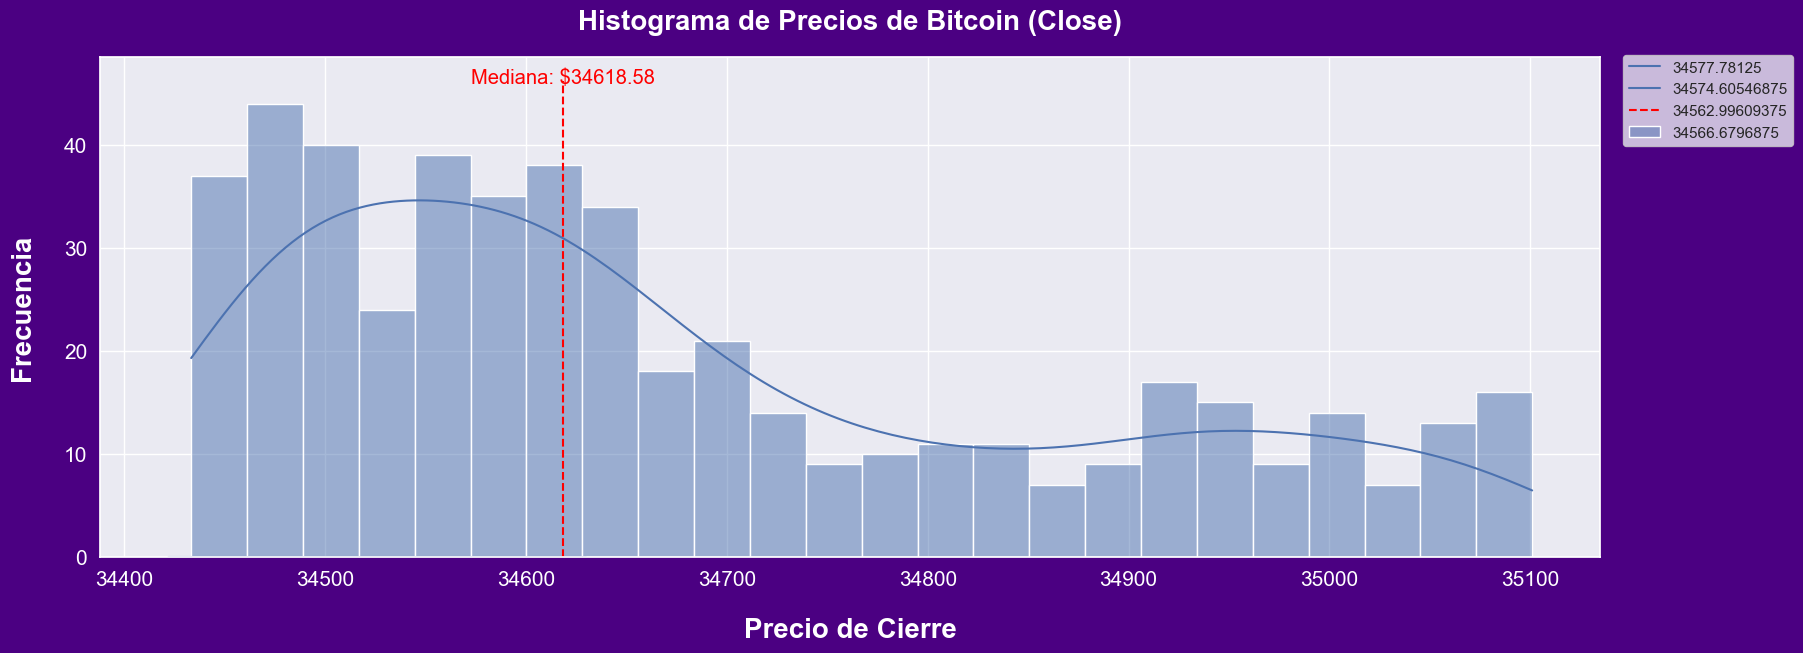

In [6]:
def hist():
    fig = plt.figure(figsize=(15, 5), facecolor='indigo')
    eje = fig.add_axes([0, 0, 1, 1])
    datos_limpios = limpieza_datos()[0]
    close = datos_limpios['Close']
    datos_limpios['Close'].head(10).plot.density()
    # eje.hist(close, bins=30, color='skyblue', edgecolor='black')
    sns.histplot(data=datos_limpios, x=close,bins=24, kde=True );
    mediana = close.median()
    eje.vlines(x=mediana, ymin=0, ymax=eje.get_ylim()[1], color='red', linestyle='dashed', label='Mediana')
    eje.set_title('Histograma de Precios de Bitcoin (Close)', fontsize=20, fontweight='bold', color='w', pad=20)
    eje.set_xlabel('Precio de Cierre', fontsize=20, fontweight='bold', color='w', labelpad=20)
    eje.set_ylabel('Frecuencia', fontsize=20, fontweight='bold', color='w', labelpad=20)
    eje.tick_params(axis='x', colors='w', labelsize=15)
    eje.tick_params(axis='y', colors='w', labelsize=15)
    eje.annotate(f'Mediana: ${round(mediana, 2)}', xy=(mediana, eje.get_ylim()[1]-1.05), ha='center', va='top', color='red', fontsize=14.5)
    plt.legend(close,bbox_to_anchor=(1.01, 1.02), loc='upper left')
    plt.gray()
    plt.show()
hist()

In [7]:
datos_limpios.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-30 00:05:00+00:00,34559.351562,34577.847656,34559.296875,34577.781250,3096576,0.0,0.0
2023-10-30 00:10:00+00:00,34573.507812,34574.605469,34554.511719,34574.605469,18130944,0.0,0.0
2023-10-30 00:15:00+00:00,34575.640625,34575.640625,34557.765625,34562.996094,20442112,0.0,0.0
2023-10-30 00:20:00+00:00,34557.855469,34566.679688,34557.046875,34566.679688,2438144,0.0,0.0
2023-10-30 00:25:00+00:00,34575.410156,34575.410156,34547.226562,34547.226562,4829184,0.0,0.0


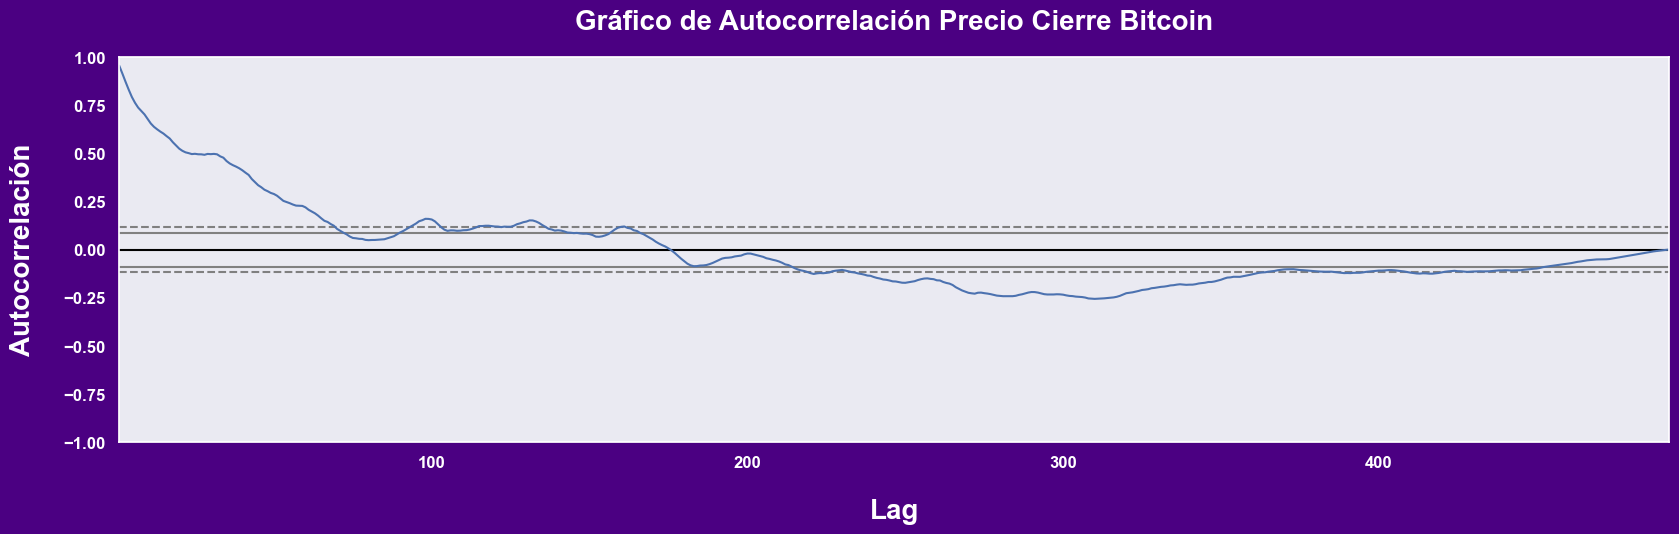

In [8]:
def autocorrelacion():
    plt.figure(figsize=(20, 5), facecolor='indigo')
    autocorrelation_plot(datos_limpios['Close'])
    plt.title('Gráfico de Autocorrelación Precio Cierre Bitcoin',color='w', size=20, fontweight='bold', loc='center', pad=20)
    plt.xlabel('Lag',color='w', fontweight='bold', size=20, labelpad=20)
    plt.ylabel('Autocorrelación',color='w',fontweight='bold', size=20, labelpad=20)
    plt.xticks(fontweight='bold', fontsize=12, color='white')  
    plt.yticks(fontweight='bold', fontsize=12, color='white')  
    plt.show()
autocorrelacion()

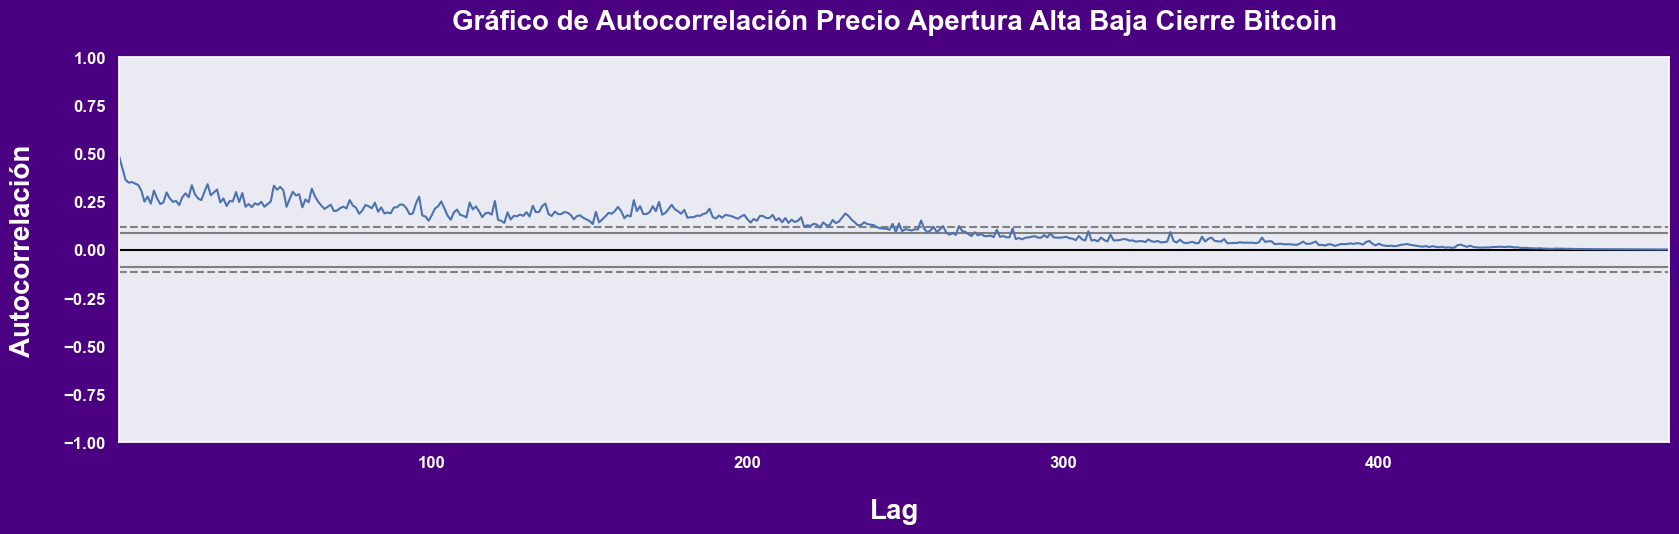

In [9]:
def autocorrelacion():
    plt.figure(figsize=(20, 5), facecolor='indigo')
    autocorrelation_plot(datos_limpios)
    plt.title('Gráfico de Autocorrelación Precio Apertura Alta Baja Cierre Bitcoin',color='w', size=20, fontweight='bold', loc='center', pad=20)
    plt.xlabel('Lag',color='w', fontweight='bold', size=20, labelpad=20)
    plt.ylabel('Autocorrelación',color='w',fontweight='bold', size=20, labelpad=20)
    plt.xticks(fontweight='bold', fontsize=12, color='white')  
    plt.yticks(fontweight='bold', fontsize=12, color='white')  
    plt.show()
autocorrelacion()

In [10]:
datos_limpios

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-30 00:05:00+00:00,34559.351562,34577.847656,34559.296875,34577.781250,3096576,0.0,0.0
2023-10-30 00:10:00+00:00,34573.507812,34574.605469,34554.511719,34574.605469,18130944,0.0,0.0
2023-10-30 00:15:00+00:00,34575.640625,34575.640625,34557.765625,34562.996094,20442112,0.0,0.0
2023-10-30 00:20:00+00:00,34557.855469,34566.679688,34557.046875,34566.679688,2438144,0.0,0.0
2023-10-30 00:25:00+00:00,34575.410156,34575.410156,34547.226562,34547.226562,4829184,0.0,0.0
...,...,...,...,...,...,...,...
2023-11-05 16:45:00+00:00,34978.062500,34979.531250,34976.914062,34976.914062,1499136,0.0,0.0
2023-11-05 16:50:00+00:00,34977.593750,34990.343750,34974.988281,34990.343750,2570240,0.0,0.0
2023-11-05 16:55:00+00:00,34982.968750,34983.988281,34977.289062,34979.707031,14399488,0.0,0.0


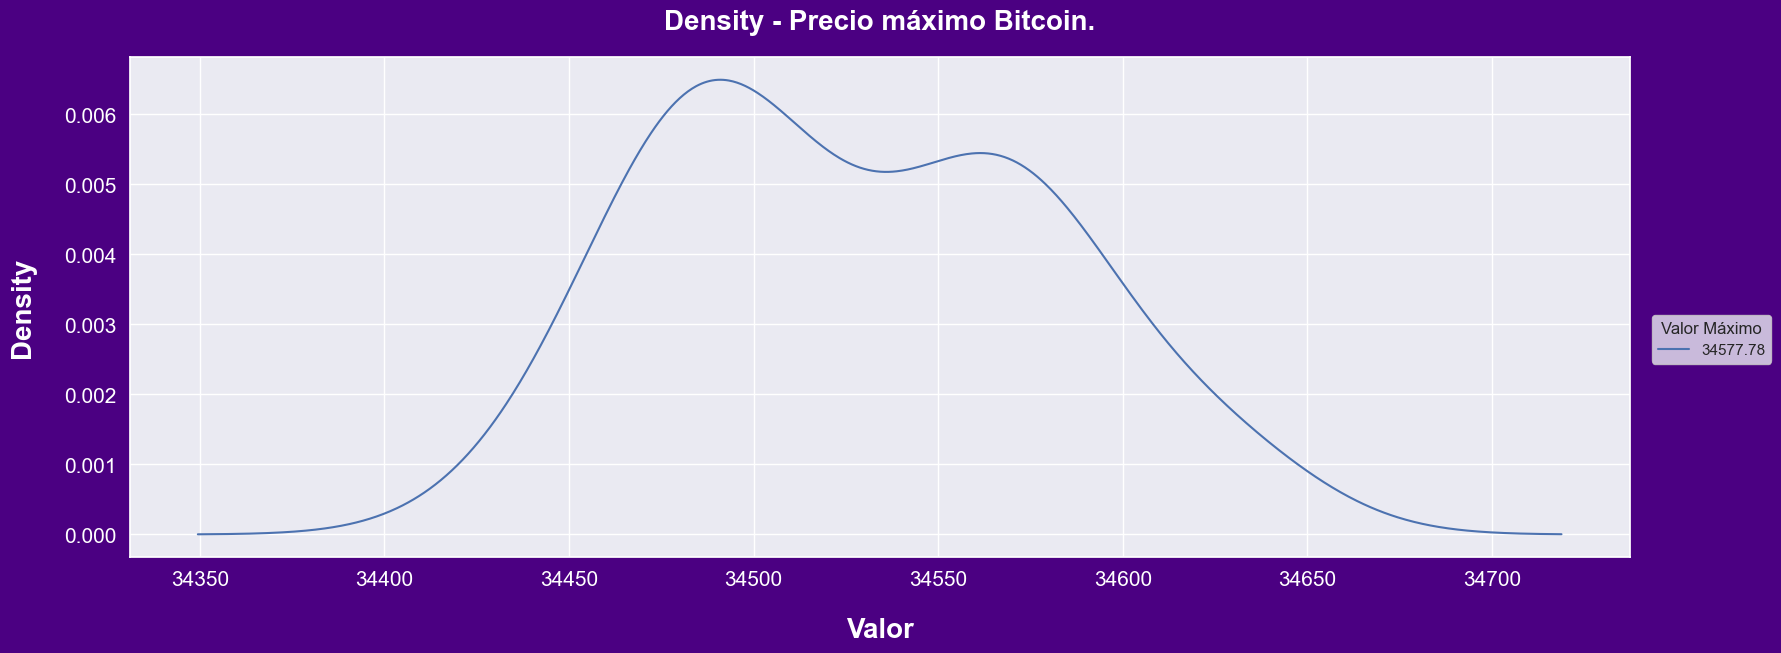

In [11]:
def density():
    fig = plt.figure(figsize=(15, 5), facecolor='indigo')
    eje = fig.add_axes([0, 0, 1, 1])
    plt.title('Density - Precio máximo Bitcoin.', color='w', size=20, fontweight='bold',pad=20)
    plt.ylabel( 'Datetime',fontsize=20, fontweight='bold', color='w', labelpad=20)
    plt.xlabel( 'Valor',fontsize=20, fontweight='bold', color='w', labelpad=20)
    eje.tick_params(axis='x', colors='w', labelsize=15)
    eje.tick_params(axis='y', colors='w', labelsize=15)
    datos_limpios['Close'].head(24).plot.density();
    close = datos_limpios['Close'].head(24)
    plt.legend(round(close.head(24), 2),bbox_to_anchor=(1.01, 0.5), loc='upper left', title='Valor Máximo');
    
density()

In [12]:
datos_limpios.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-30 00:05:00+00:00,34559.351562,34577.847656,34559.296875,34577.781250,3096576,0.0,0.0
2023-10-30 00:10:00+00:00,34573.507812,34574.605469,34554.511719,34574.605469,18130944,0.0,0.0
2023-10-30 00:15:00+00:00,34575.640625,34575.640625,34557.765625,34562.996094,20442112,0.0,0.0
2023-10-30 00:20:00+00:00,34557.855469,34566.679688,34557.046875,34566.679688,2438144,0.0,0.0
2023-10-30 00:25:00+00:00,34575.410156,34575.410156,34547.226562,34547.226562,4829184,0.0,0.0


In [13]:
datos_limpios = limpieza_datos()[0]

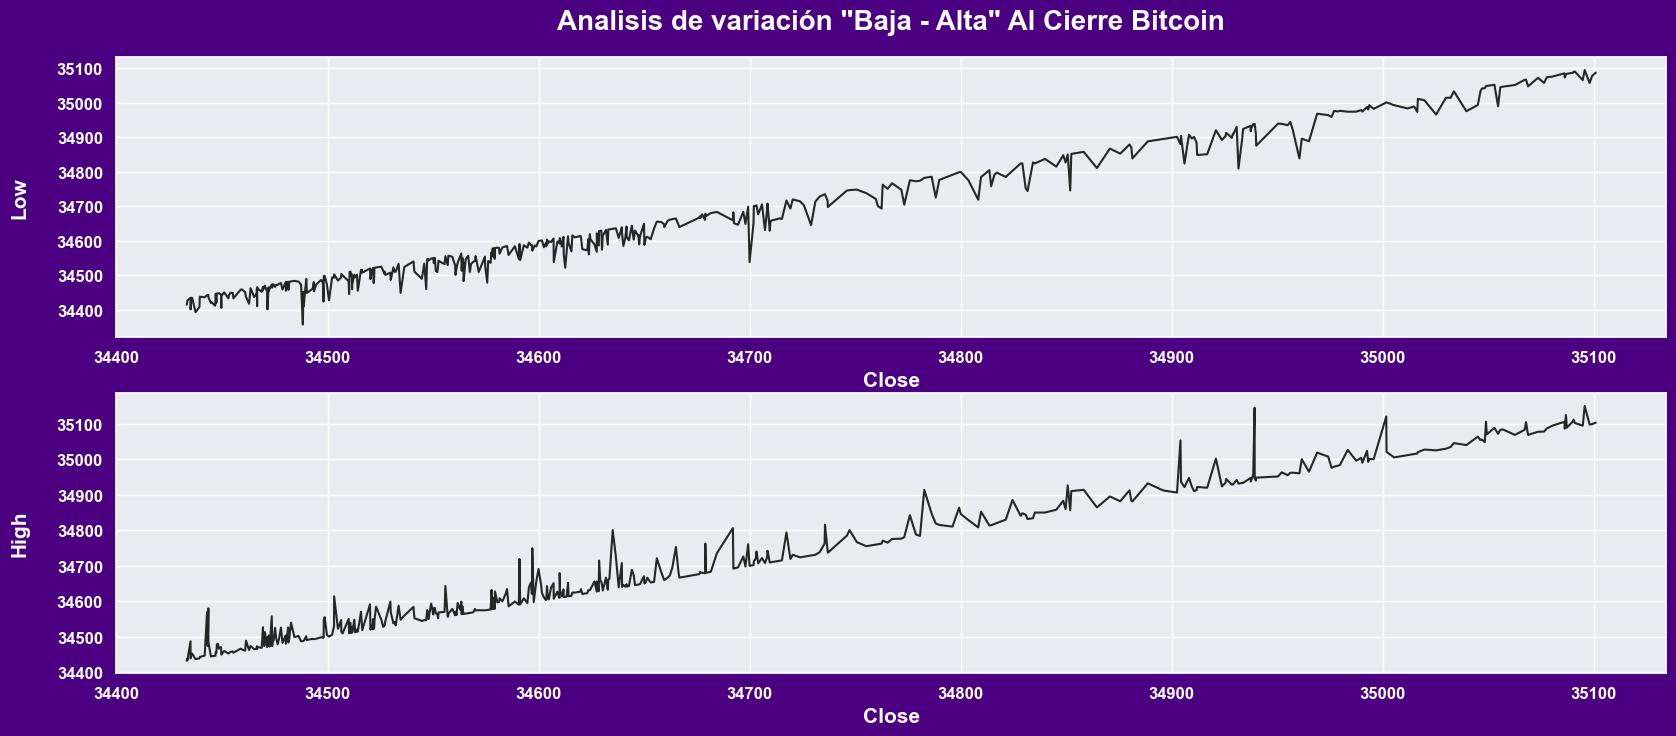

In [14]:
def comparacion_grafico(titulo, dataset, x, y1, y2):
    plt.figure(figsize=(20, 8), facecolor='indigo')
    sns.set(style="darkgrid")
    sns.set_palette('dark:skyblue')
    ax = plt.subplot(2,1,1)
    ax.set_title(titulo, color='w', size=20, fontweight='bold', loc='center', pad=20)
    sns.lineplot(data=dataset, x=x, y=y1 )
    plt.ylabel(y1, color='w',fontweight='bold', size=15,labelpad=20)
    plt.xlabel('Close', color='w',fontweight='bold', size=15)
    plt.xticks(fontweight='bold', fontsize=12, color='white')
    plt.yticks(fontweight='bold', fontsize=12, color='white')  
    plt.subplot(2,1,2)
    sns.lineplot(data=dataset, x=x, y=y2 )
    plt.ylabel(y2, color='w',fontweight='bold', size=15,labelpad=20)
    plt.xlabel('Close', color='w',fontweight='bold', size=15)
    plt.xticks(fontweight='bold', fontsize=12, color='white')
    plt.yticks(fontweight='bold', fontsize=12, color='white')  
    plt.show()
comparacion_grafico('Analisis de variación "Baja - Alta" Al Cierre Bitcoin', datos_limpios.head(720), 'Close', 'Low', 'High')

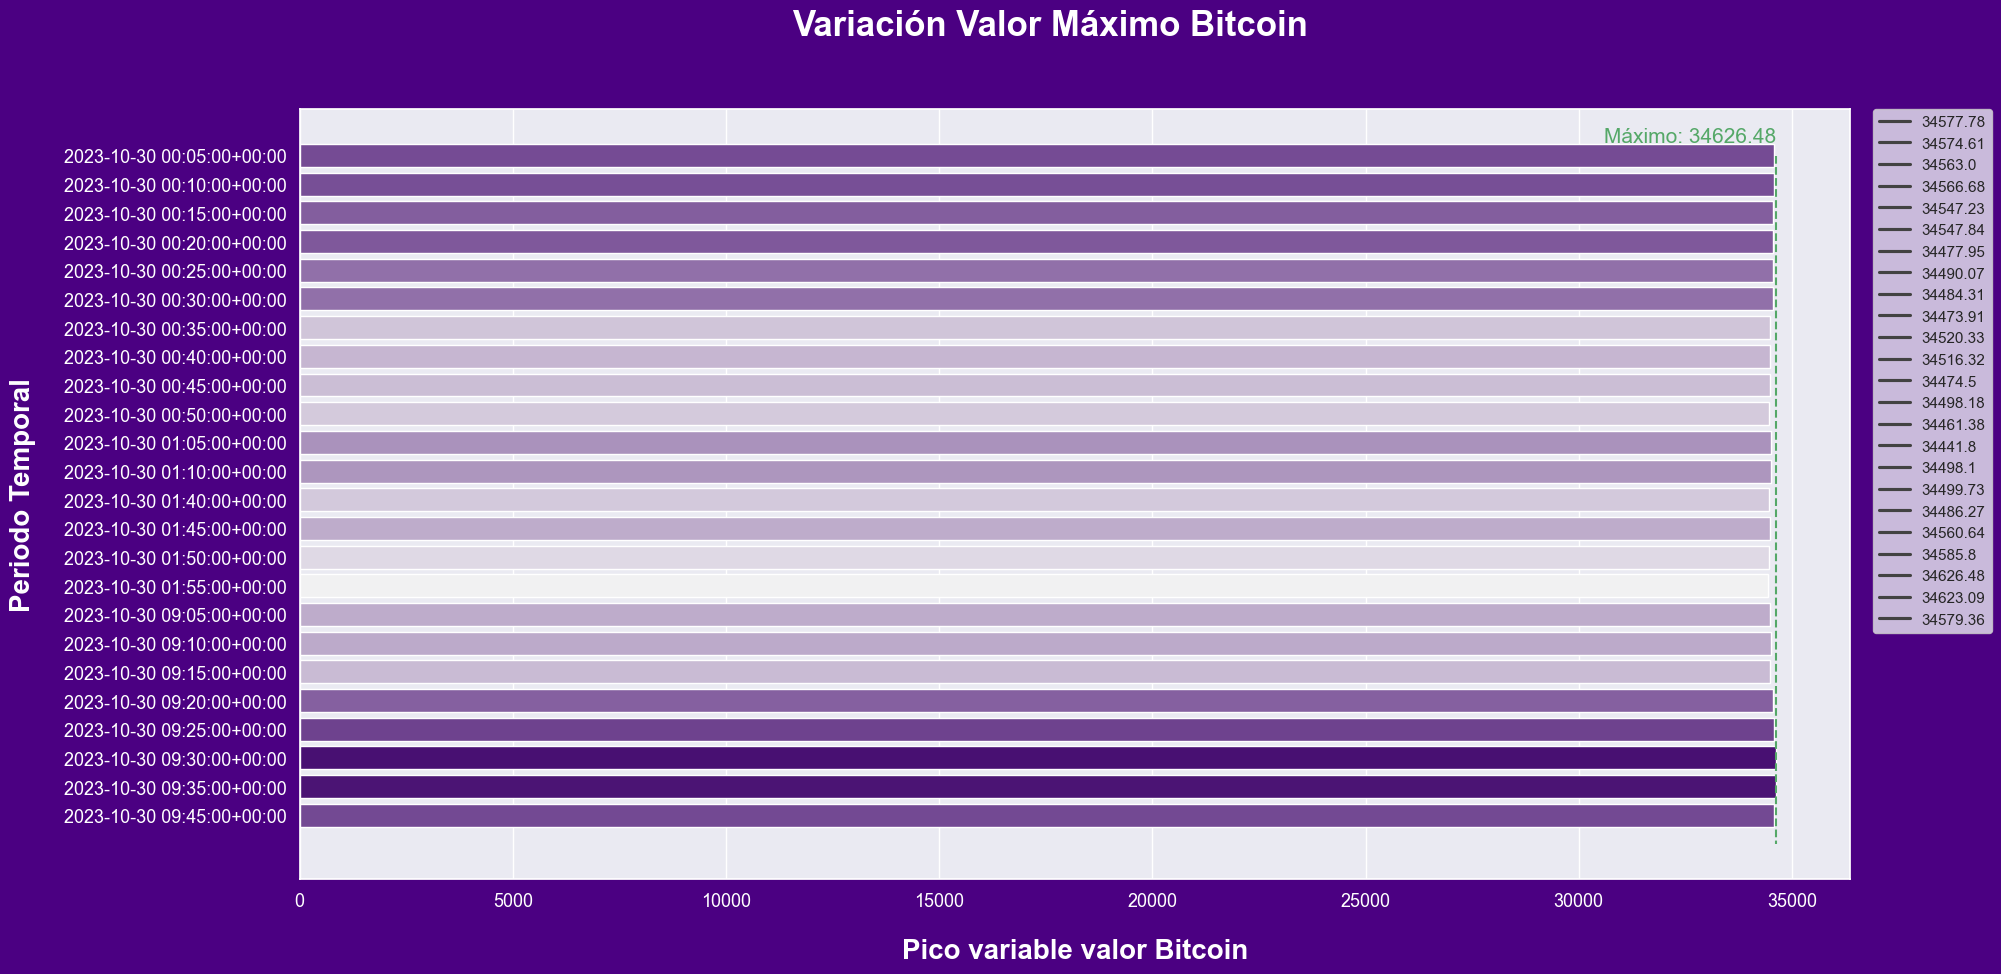

In [15]:
def maximo_ultimas():
    plt.figure(figsize=(20, 10), facecolor='indigo')
    datos_limpios = limpieza_datos()[0]
    close = datos_limpios['Close']
    sns.barplot( data=datos_limpios.head(24), x='Close', y='Datetime', hue='Close', palette='light:indigo');
    plt.suptitle('Variación Valor Máximo Bitcoin', color='w', fontsize=25, fontweight='bold')
    plt.xlabel('Pico variable valor Bitcoin',color='w', size=20, fontweight='bold', labelpad=20)
    plt.ylabel('Periodo Temporal', color='w', size=20, fontweight='bold', labelpad=20)
    plt.tick_params(axis='x', colors='w', labelsize=13)
    plt.tick_params(axis='y', colors='w',labelsize=13)
    maximos = round(datos_limpios.head(24)[datos_limpios.head(24)['Close'] == datos_limpios.head(24)['Close'].max()], 2)
    plt.vlines(x=maximos['Close'], ymin=0, ymax=len(datos_limpios.head(24)), colors='g', linestyles='dashed', label='Máximo')
    for index, row in maximos.iterrows():
        plt.text(row['Close'], len(datos_limpios.head(24)) - 25, f'Máximo: {row["Close"]}', fontsize=15, ha='right', va='top', color='g')
    plt.gray()
    plt.legend(round(close.head(24), 2),bbox_to_anchor=(1.01, 1.01), loc='upper left')
    plt.show()
maximo_ultimas()

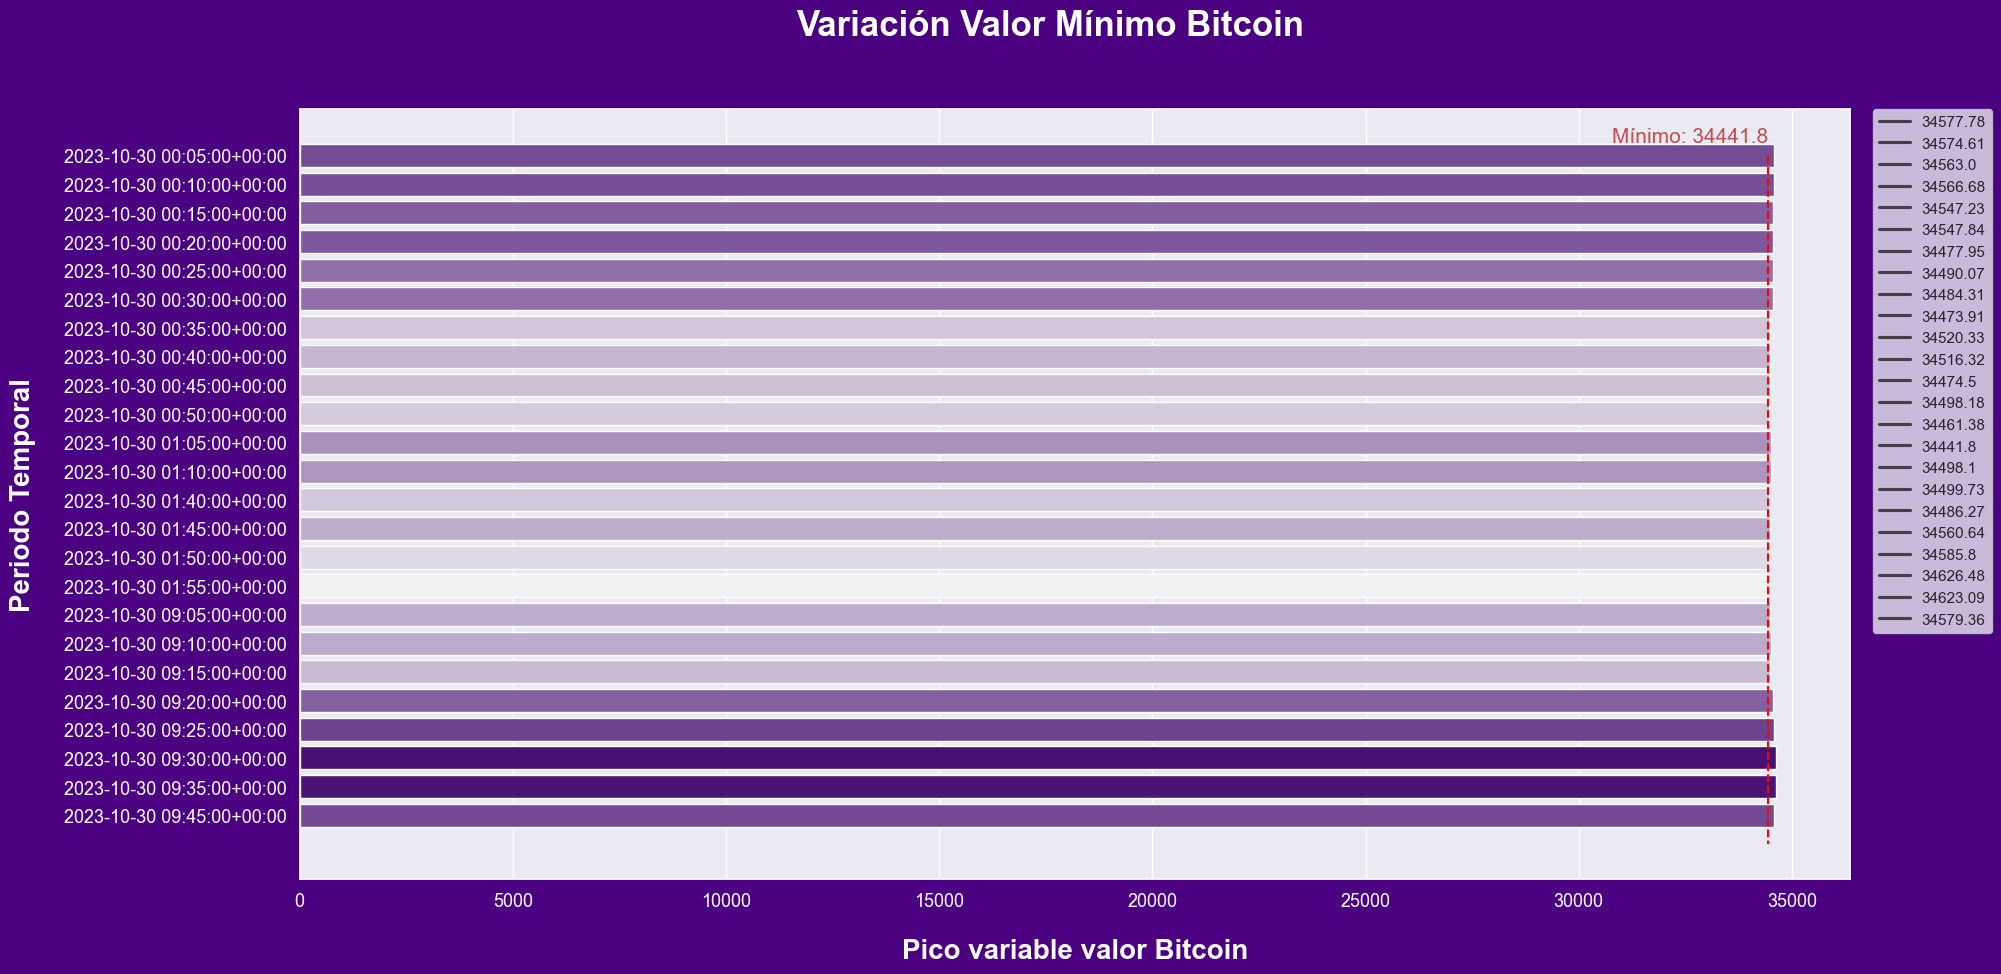

In [16]:
def minimo_ultimas():
    plt.figure(figsize=(20, 10), facecolor='indigo')
    datos_limpios = limpieza_datos()[0]
    close = datos_limpios['Close']

    # sns.set(style="darkgrid")
    sns.barplot( data=datos_limpios.head(24), x='Close', y='Datetime', hue='Close', palette='light:indigo');
    plt.suptitle('Variación Valor Mínimo Bitcoin', color='w', fontsize=25, fontweight='bold')
    plt.xlabel('Pico variable valor Bitcoin',color='w', size=20, fontweight='bold', labelpad=20)
    plt.ylabel('Periodo Temporal', color='w', size=20, fontweight='bold', labelpad=20)
    plt.tick_params(axis='x', colors='w', labelsize=13)
    plt.tick_params(axis='y', colors='w',labelsize=13)
    maximos = round(datos_limpios.head(24)[datos_limpios.head(24)['Close'] == datos_limpios.head(24)['Close'].min()], 2)
    plt.vlines(x=maximos['Close'], ymin=0, ymax=len(datos_limpios.head(24)), colors='red', linestyles='dashed', label='Mínimos')
    for index, row in maximos.iterrows():
        plt.text(row['Close'], len(datos_limpios.head(24)) - 25, f'Mínimo: {row["Close"]}', fontsize=15, ha='right', va='top', color='r')
    plt.gray()
    plt.legend(round(close.head(24), 2),bbox_to_anchor=(1.01, 1.01), loc='upper left')
    plt.show()
minimo_ultimas()

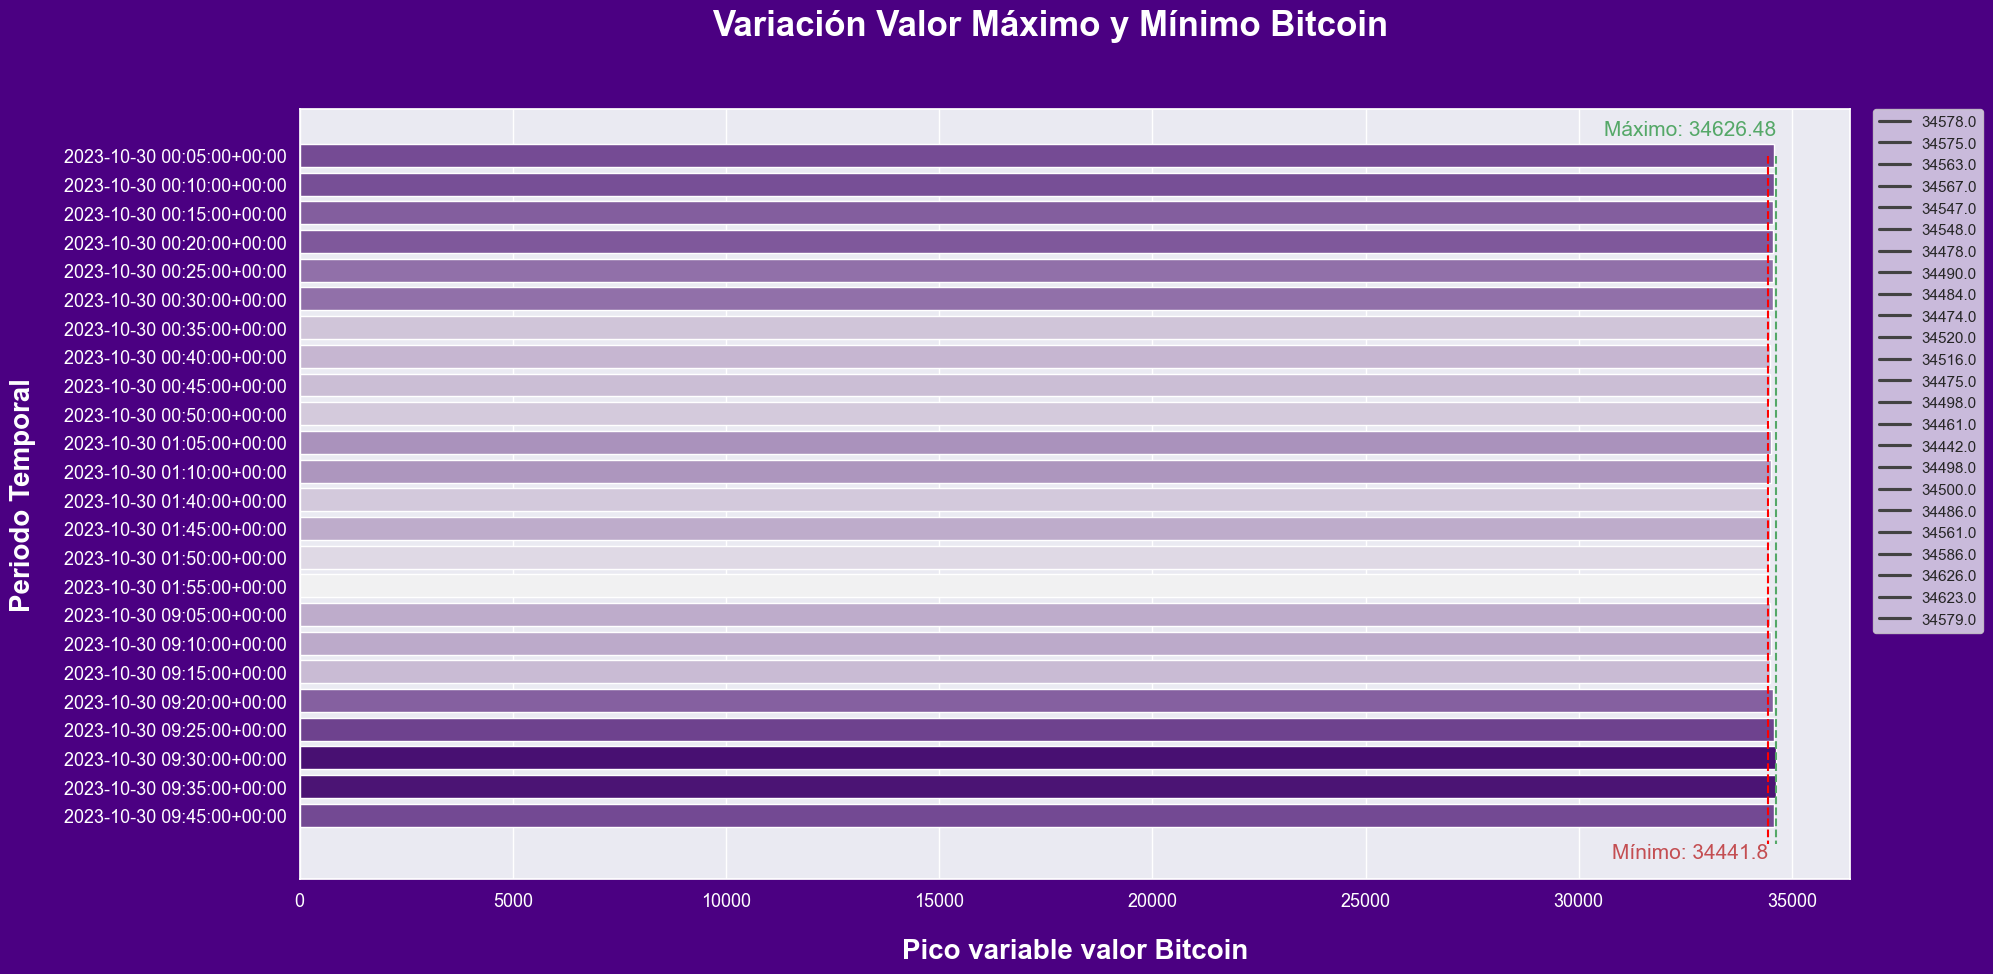

In [17]:
def maximo_minimo_ultimas():
    plt.figure(figsize=(20, 10), facecolor='indigo')
    datos_limpios = limpieza_datos()[0]
    close = datos_limpios['Close']
    sns.barplot( data=datos_limpios.head(24), x='Close', y='Datetime', hue='Close', palette='light:indigo');
    plt.suptitle('Variación Valor Máximo y Mínimo Bitcoin', color='w', fontsize=25, fontweight='bold')
    plt.xlabel('Pico variable valor Bitcoin',color='w', size=20, fontweight='bold', labelpad=20)
    plt.ylabel('Periodo Temporal', color='w', size=20, fontweight='bold', labelpad=20)
    plt.tick_params(axis='x', colors='w', labelsize=13)
    plt.tick_params(axis='y', colors='w',labelsize=13)

    maximo = round(datos_limpios.head(24)['Close'].max(), 2)
    minimo = round(datos_limpios.head(24)['Close'].min(), 2)

    plt.vlines(x=maximo, ymin=0, ymax=len(datos_limpios.head(24)), colors='g', linestyles='dashed', label='Máximos')
    plt.vlines(x=minimo, ymin=0, ymax=len(datos_limpios.head(24)), colors='red', linestyles='dashed', label='Mínimos')

    plt.text(maximo, len(datos_limpios.head(24)) - 25.25, f'Máximo: {maximo}', fontsize=15, ha='right', va='top', color='g')
    plt.text(minimo, len(datos_limpios.head(24)) - 0.05, f'Mínimo: {minimo}', fontsize=15, ha='right', va='top', color='r')

    plt.gray()
    plt.legend(round(close.head(24)),bbox_to_anchor=(1.01, 1.01), loc='upper left')
    plt.show()
maximo_minimo_ultimas()

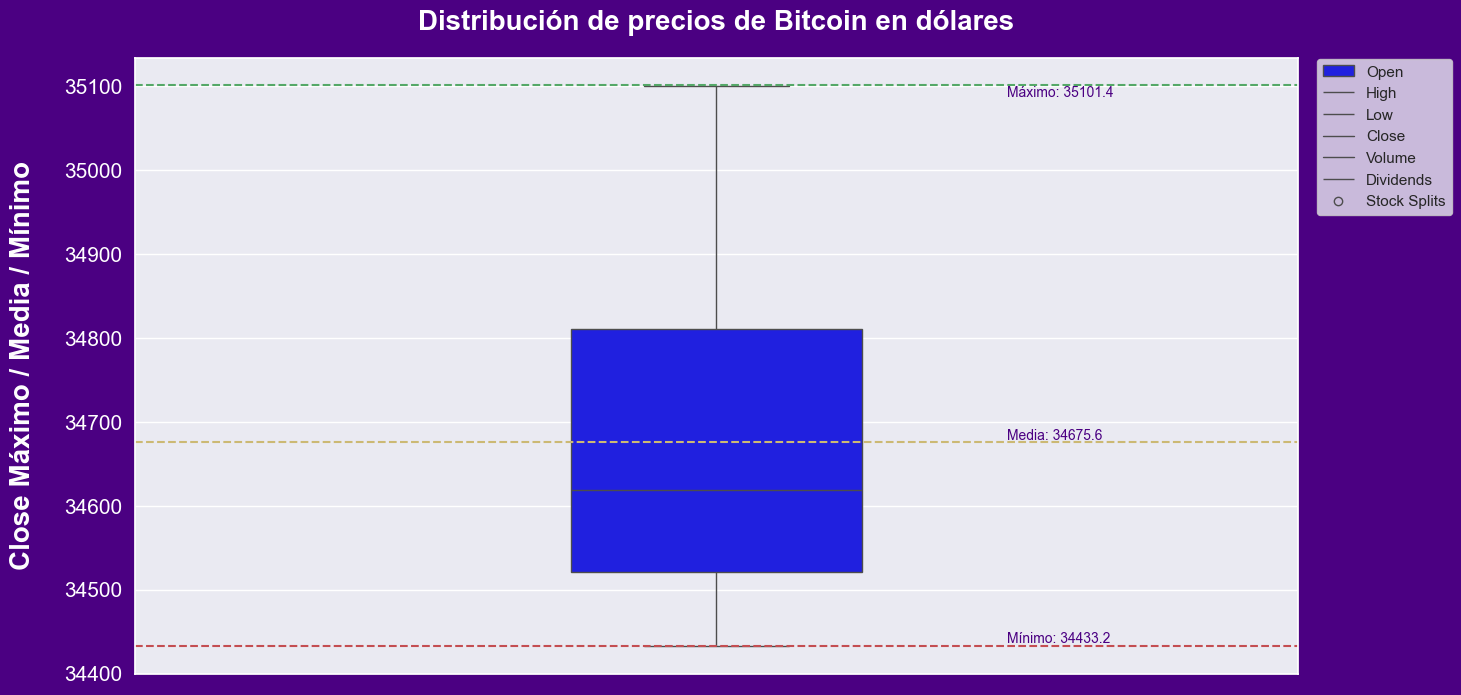

In [18]:
def boxplot1():
  # sns.set(style="darkgrid")
  plt.figure(figsize=(15, 8), facecolor='indigo')
  plt.tick_params(axis='x', colors='w', labelsize=15)
  plt.tick_params(axis='y', colors='w', labelsize=15)
 
  boxplot = sns.boxplot(y='Close', data=df_bitcoin_limpio, whis=2, width=0.25, color='blue')
  plt.title('Distribución de precios de Bitcoin en dólares', size=20, color='w',fontweight='bold',pad=20)
  plt.ylabel(f'Close Máximo / Media / Mínimo', color='w',fontweight='bold', size=20, labelpad=20)
  media = df_bitcoin_limpio['Close'].mean()
  maximo = limpieza_datos()[2]
  minimo = limpieza_datos()[1]

  boxplot.axhline(y=maximo, color='g', linestyle='--')
  boxplot.axhline(y=media, color='y', linestyle='--') 
  boxplot.axhline(y=minimo, color='r', linestyle='--') 
  
  plt.text(x=0.25, y=limpieza_datos()[2], s=f'Máximo: {limpieza_datos()[2].round(1)}', fontsize=10, va='top', color='indigo')
  plt.text(x=0.25, y=media, s=f'Media: {media.round(1)}', fontsize=10, va='bottom', color='indigo')
  plt.text(x=0.25, y=limpieza_datos()[1], s=f'Mínimo: {limpieza_datos()[1].round(1)}', fontsize=10, va='bottom', color='indigo')
  plt.gray()
  
  plt.legend(df_bitcoin_limpio,bbox_to_anchor=(1.01, 1.01), loc='upper left')
  return plt.show()

boxplot1()

4.Toma de desición Compra / Vanta / Espera

In [19]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, media_bitcoin, algoritmo_decision, df_bitcoin_limpio
  media_bitcoin = df_bitcoin_limpio['Close'].mean()
  if precio_actual >= media_bitcoin and tendencia == 'baja':
    algoritmo_decision = '-- Vender --'
  elif precio_actual < media_bitcoin and tendencia == 'alta':
    algoritmo_decision = '-- Comprar --'
    return algoritmo_decision
  else:
    algoritmo_decision = '-- Esperar --'
  
  return algoritmo_decision
tomar_decisiones()

'-- Esperar --'

5.Visualizando los datos / Variación de los últimos 7 días

In [20]:
def visualizacion():
  df_bitcoin['Promedio'] = media_bitcoin
  plt.figure(figsize=(16, 5), facecolor='indigo')
  plt.title('Comprar, vender o esperar', fontsize=20,fontweight='bold', color='w', pad=20)
  plt.plot(df_bitcoin.index, df_bitcoin['Close'], color='indigo')
  plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], ls='--', color='k')
  plt.tick_params(axis='x', colors='w', labelsize=13)
  plt.tick_params(axis='y', colors='w',labelsize=13)
  plt.xlabel('Datos variación precio Bitcoin de los últimos 7 días.', fontsize=20, fontweight='bold', color='w', labelpad=20)
  plt.annotate(f'Decisión: {algoritmo_decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(-220, 90), textcoords='offset points', fontsize=13, color='green',fontweight='bold')
  plt.show()

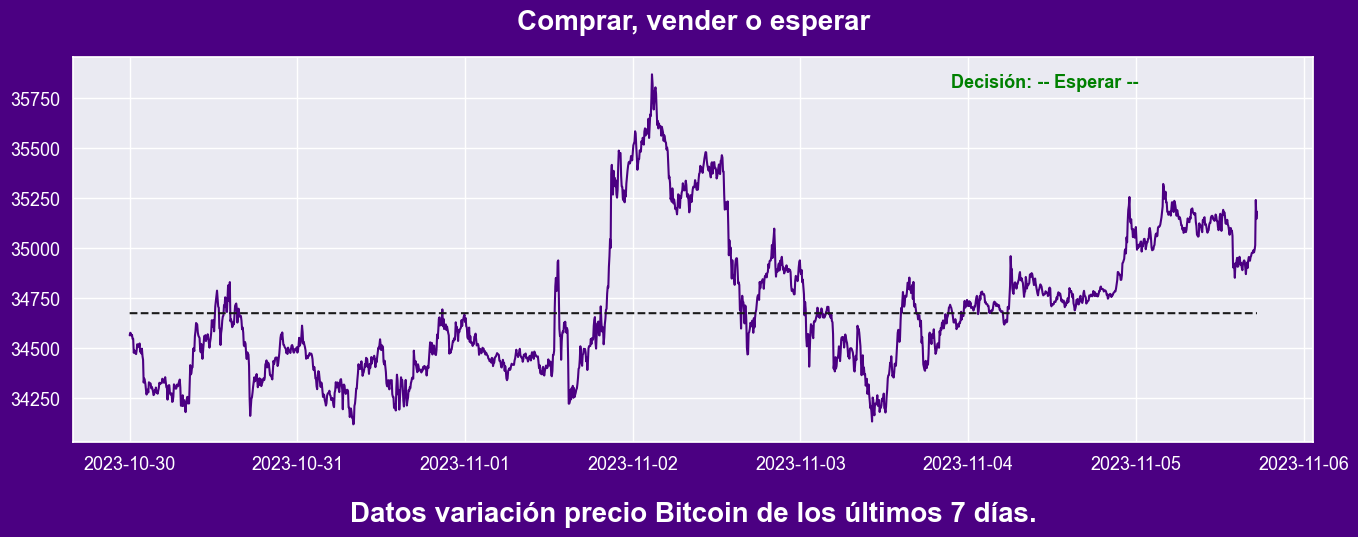

In [21]:
visualizacion()

In [22]:
datos_limpios.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-30 00:05:00+00:00,34559.351562,34577.847656,34559.296875,34577.781250,3096576,0.0,0.0
2023-10-30 00:10:00+00:00,34573.507812,34574.605469,34554.511719,34574.605469,18130944,0.0,0.0
2023-10-30 00:15:00+00:00,34575.640625,34575.640625,34557.765625,34562.996094,20442112,0.0,0.0
2023-10-30 00:20:00+00:00,34557.855469,34566.679688,34557.046875,34566.679688,2438144,0.0,0.0
2023-10-30 00:25:00+00:00,34575.410156,34575.410156,34547.226562,34547.226562,4829184,0.0,0.0


6.Automatizamos el sistema 

Precio actual de Bitcoin: 35167.47
Tendencia: alta
Variación: 0.62%
Hora de verificación: 14:19:33
Ejecuciones: 1
Decisión: -- Esperar --


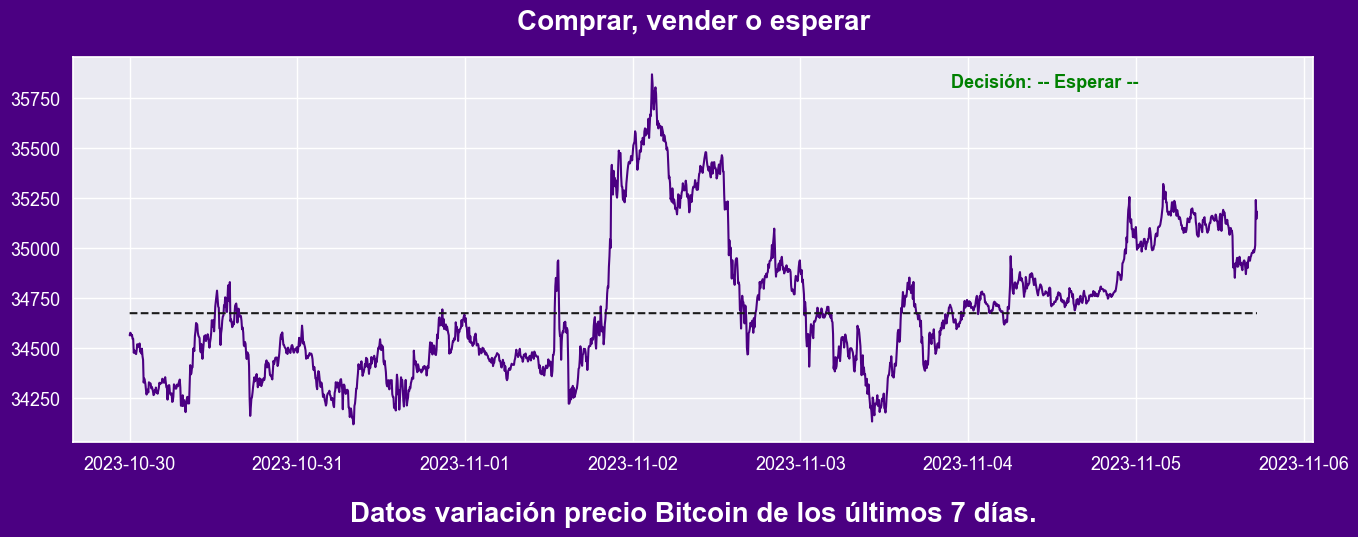

In [23]:
  
def automatizado(): 
  contador = 0 
  while True:
    contador += 1
    clear_output(wait=True)
    importar_base_bitcoin()
    extraer_tendencias()
    limpieza_datos()
    tomar_decisiones()
    tz = pytz.timezone('America/Argentina/Buenos_Aires')
    now = datetime.datetime.now(tz)
    print("Hora de verificación:", now.strftime("%H:%M:%S"))
    print(f'Ejecuciones: {contador}')
    print('Decisión:', tomar_decisiones())
    visualizacion()
    time.sleep(300)
automatizado()


La toma de datos de variación de precio del bitcoin de los últimos 7 días es un proceso que consiste en recopilar información sobre el precio del bitcoin en un período de tiempo determinado. Esta información se puede utilizar para realizar análisis de tendencias y proyecciones del precio futuro de la moneda.
En nuestro caso para la toma de desiciones de Compra / Venta / Espera según situación y conveniencia.
Web scraping: Este método permite extraer datos de una página web utilizando un script o programa.
Una vez que se han recopilado los datos, se pueden almacenar en una base de datos o en un archivo CSV. Los datos se pueden analizar utilizando una variedad de herramientas y técnicas, como hojas de cálculo, software de análisis de datos y lenguajes de programación.
Una vez que se han recopilado los datos, se pueden analizar para obtener información sobre la variación de precio del bitcoin de los últimos 7 días. Por ejemplo, se puede calcular el rendimiento diario del bitcoin o el porcentaje de variación de precio del bitcoin en un período de tiempo determinado.

#### Hacemos de algo simple algo extraordinario 🚀👨‍🚀